# Домашняя работа. Яндекс.Маркет. Часть 1

Задача: увеличение LTV за счет уменьшения оттока пользователей и увеличения частоты контакта<br>

Ключевые этапы решения:
1. Обработать данные<br>
2. Сделать RFM-анализ<br>
3. Подготовить рекомендации команде сервиса<br>
4. Предложить проект по увеличению LTV и оценить потенциальную пользу от этого проекта

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.interpolate import interp1d

In [5]:
rfm = pd.read_csv('/Users/mac/Downloads/rfm.tsv', sep='\t', header = None, encoding='latin-1', index_col=False, names=['hit timestamp','user_id','url','geo_id','category','price'], low_memory=False)

timestamp хита <br>
user_id <br>
url - url хита или "click", если пользователь перешел в интернет-магазин <br>
geo_id - идентификатор региона пользователя <br>
category - идентификатор категории <br>
price - стоимость клика, если пользователь перешел в интернет-магазин <br>

# 1. Обработка датафреймов 

In [6]:
rfm.shape

(10007147, 6)

In [7]:
rfm.head()

,hit timestamp,user_id,url,geo_id,category,price
0,1380052543,00002ad98ae4290672431d702c211b4a,/_c/YwrVrj_29IVZDmKxglT53wo7Pk8.html,10000,NaN,NaN
1,1375703582,00003cb9076039f584a12c2036fd3602,/gate/cart-list.xml?sk=y5fc6079b758f5a4e3646a8...,10000,NaN,NaN
2,1374479873,00003cb9076039f584a12c2036fd3602,/gate/cart-list.xml?sk=yd6558780959d5130b32e1a...,10000,NaN,NaN
3,1374479892,00003cb9076039f584a12c2036fd3602,/gate/cart-list.xml?sk=yd6558780959d5130b32e1a...,10000,NaN,NaN
4,1374480337,00003cb9076039f584a12c2036fd3602,/gate/cart-list.xml?sk=yd6558780959d5130b32e1a...,10000,NaN,NaN


<br>
<br>
Работа с hit timestamp

In [8]:
rfm['hit timestamp'] = pd.to_datetime(rfm['hit timestamp'], unit='s') 

In [9]:
rfm.head()

,hit timestamp,user_id,url,geo_id,category,price
0,2013-09-24 19:55:43,00002ad98ae4290672431d702c211b4a,/_c/YwrVrj_29IVZDmKxglT53wo7Pk8.html,10000,NaN,NaN
1,2013-08-05 11:53:02,00003cb9076039f584a12c2036fd3602,/gate/cart-list.xml?sk=y5fc6079b758f5a4e3646a8...,10000,NaN,NaN
2,2013-07-22 07:57:53,00003cb9076039f584a12c2036fd3602,/gate/cart-list.xml?sk=yd6558780959d5130b32e1a...,10000,NaN,NaN
3,2013-07-22 07:58:12,00003cb9076039f584a12c2036fd3602,/gate/cart-list.xml?sk=yd6558780959d5130b32e1a...,10000,NaN,NaN
4,2013-07-22 08:05:37,00003cb9076039f584a12c2036fd3602,/gate/cart-list.xml?sk=yd6558780959d5130b32e1a...,10000,NaN,NaN


In [10]:
start = rfm['hit timestamp'].min()
finish = rfm['hit timestamp'].max()
period_rfm = finish - start # estimating period of time
print('Start: ', start, '; End: ', finish, '; \nPeriod of time: ', period_rfm)

Start:  2012-12-31 20:00:53 ; End:  2013-12-31 19:58:37 ; 
Period of time:  364 days 23:57:44


>Мы видим, что данные собраны за 1 год

<br>
<br>
Работа с user_id

In [13]:
rfm["user_id"].value_counts()

defeadb89b8be2537812b0f27f5a1eb8    65317
3b5c0880306da1c4fa446aec760665e6    50946
04337c2d13423a3f2980e6625ef7da1c    22703
e8dc5428bb4ec274f70d19fa574b73c8    21519
7a6d194bd452a1b89a817512f4e6a22c    19979
                                    ...  
ebfffe2e0ba9ef9ff3d77fbe8a545cf0        1
cbcba87cf203b6bc93aee62b3e6b3d7c        1
2356e549962ab7dbec9607896553c624        1
1e5f98253e11f89c613f67d394b87290        1
b1a48e8ed54ca193afce763c8647cea3        1
Name: user_id, Length: 299208, dtype: int64

In [14]:
rfm["user_id"].describe()

count                             10007147
unique                              299208
top       defeadb89b8be2537812b0f27f5a1eb8
freq                                 65317
Name: user_id, dtype: object

траффик

In [15]:
rfm['hit timestamp'] = rfm['hit timestamp'].astype(str).str.split(' ').str[0]

In [16]:
rfm['hit timestamp'] = rfm['hit timestamp'].astype(str).str.split('-').str[1]

In [17]:
rfm.iloc[:, :2]

,hit timestamp,user_id
0,09,00002ad98ae4290672431d702c211b4a
1,08,00003cb9076039f584a12c2036fd3602
2,07,00003cb9076039f584a12c2036fd3602
3,07,00003cb9076039f584a12c2036fd3602
4,07,00003cb9076039f584a12c2036fd3602
...,...,...
10007142,02,fffffdbc5c7fbe34b444d9c213bba286
10007143,02,fffffdbc5c7fbe34b444d9c213bba286
10007144,02,fffffdbc5c7fbe34b444d9c213bba286
10007145,02,fffffdbc5c7fbe34b444d9c213bba286


In [18]:
traf = rfm['hit timestamp'].value_counts()
traffic = pd.DataFrame(traf)
traffic

,hit timestamp
12,1250520
11,1059181
09,902542
07,863831
10,861098
04,811711
08,790919
05,768514
06,763631
03,686591


Text(0.5, 1.0, 'traffic per month')

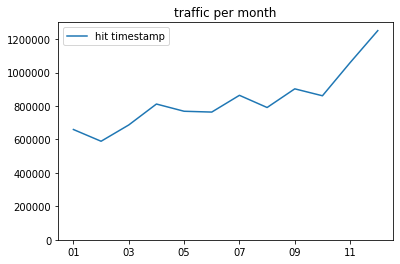

In [19]:
traffic.reindex(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']).plot(kind="line", ylim=(0, 1300000))
plt.title("traffic per month")

In [20]:
rfm2 = pd.read_csv('/Users/mac/Downloads/rfm.tsv', sep='\t', header = None, encoding='latin-1', index_col=False, names=['hit timestamp','user_id','url','geo_id','category','price'], low_memory=False)

In [21]:
rfm2['hit timestamp'] = pd.to_datetime(rfm2['hit timestamp'], unit='s') 

In [22]:
rfm2['hit timestamp'] = rfm2['hit timestamp'].astype(str).str.split(' ').str[1]

In [23]:
rfm2['hit timestamp'] = rfm2['hit timestamp'].astype(str).str.split(':').str[0]

In [24]:
rfm2.iloc[:, :2]

,hit timestamp,user_id
0,19,00002ad98ae4290672431d702c211b4a
1,11,00003cb9076039f584a12c2036fd3602
2,07,00003cb9076039f584a12c2036fd3602
3,07,00003cb9076039f584a12c2036fd3602
4,08,00003cb9076039f584a12c2036fd3602
...,...,...
10007142,14,fffffdbc5c7fbe34b444d9c213bba286
10007143,14,fffffdbc5c7fbe34b444d9c213bba286
10007144,14,fffffdbc5c7fbe34b444d9c213bba286
10007145,14,fffffdbc5c7fbe34b444d9c213bba286


In [25]:
traf2 = rfm2['hit timestamp'].value_counts()
traffic2 = pd.DataFrame(traf2)
print(traffic2.max(), traffic2.min())
traffic2

hit timestamp    620111
dtype: int64 hit timestamp    86459
dtype: int64


,hit timestamp
17,620111
11,605110
10,605101
12,604254
09,601847
18,600511
13,591355
16,585434
15,574188
08,571864


Text(0.5, 1.0, 'traffic per day')

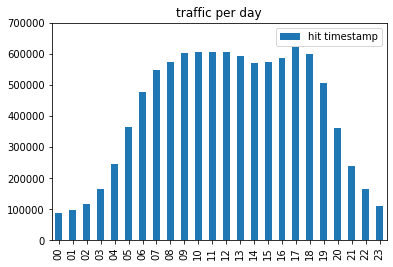

In [26]:
traffic2.reindex(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']).plot(kind="bar", ylim=(0, 700000))
plt.title("traffic per day")

>Всего 299 208 пользователей (уникальных) за период <br>Наиболее активный пользователь defeadb89b8be2537812b0f27f5a1eb8, всего 65 317 хитов за год<br>
Годовой траффик растет<br>
Пик траффика приходится на 17 часов, спад на 24 часа

<br>
<br>
Работа с url

In [27]:
rfm["url"].value_counts()

click                                                                                                                                                                                                                                                                                                                            363313
/                                                                                                                                                                                                                                                                                                                                178795
/gate/route/carter/replaceContent                                                                                                                                                                                                                                                                                                170411
/_c/YwrVrj_29IVZ

>В этой серии есть две категории данных (url и clicks). <br>P.S. об этом указанно в условии. Пока выводов отсюда  мало, вероятнее всего дальше узнаем, что к чему.

<br>
<br>
Работа с geo_id

In [28]:
geo_id = rfm['geo_id']
a = geo_id.value_counts()
geo_id1 = pd.DataFrame(a)
geo_id1.head()

,geo_id
10000,6096930
213,1832139
2,296505
54,91318
47,89190


In [29]:
id_geo = pd.read_csv('/Users/mac/Downloads/geo_table.dms', sep='\t')
id_geo1 = id_geo.rename(columns={'id': 'geo_id'})
id_geo1.head()

,geo_id,name,parent_region_id,type,TZ_OFFSET
0,1,Москва и Московская область,3.0,5,10800
1,2,Санкт-Петербург,10174.0,6,10800
2,3,Центральный федеральный округ,225.0,4,10800
3,4,Белгород,120914.0,6,10800
4,5,Иваново,120943.0,6,10800


In [30]:
b = geo_id1.merge(id_geo1)
c = b.iloc[:, 1:2]
most_cities = c['name'].value_counts()
d = pd.DataFrame(most_cities)[:20]
print('TOP городов и округов, из которых пользователи наиболее часто заходят на маркет', d)

TOP городов и округов, из которых пользователи наиболее часто заходят на маркет                                    name
Москва и Московская область         247
Санкт-Петербург                     195
Центральный федеральный округ       141
Белгород                            108
Иваново                             105
Калуга                               79
Курск                                55
Кострома                             51
Липецк                               44
Рязань                               39
Орёл                                 37
Тамбов                               33
Тула                                 29
Смоленск                             28
Сыктывкар                            26
Ярославль                            25
Тверь                                25
Архангельск                          22
Северо-Западный федеральный округ    20
Петрозаводск                         20


>Чаще всего маркетом пользуются пользователи из Москвы и ЦАО<br>
P.S. взята очень маленькая выборка из-за того, что id в файлах rfm и geo_table совпадает у очень небольшого числа пользователей

<br>
<br>
Работа с category

In [31]:
category_1 = rfm['category']
pd.DataFrame(category_1)

,category
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
10007142,4165204
10007143,4165204
10007144,294661
10007145,91033


видим, что в серии category наблюдается неоднородность типов данных<br>
чистить можно выбрав (1)числовые значения, (2)а нечисловые обработать регуляркой и достать числовые (3)  NaN и прочие символы не похожие на id котегории убрать<br>

но это не повлияет на нашу цель

In [32]:
category_2 = pd.read_csv('/Users/mac/Downloads/categories_tree.dms', sep='\t')
category_2 = category_2.rename(columns={'id': 'category'})
category_2.head()

,category,parent_id,hyper_cat_id,category_name,category_pass
0,984,978,91768,Этикет-пистолеты,\tОборудование\tОборудование для магазинов\tЭт...
1,23187,978,10469630,Рекламные дисплеи и интерактивные панели,\tОборудование\tОборудование для магазинов\tРе...
2,10411,978,5057803,Манекены,\tОборудование\tОборудование для магазинов\tМа...
3,19545,978,6509282,Терминалы сбора данных,\tОборудование\tОборудование для магазинов\tТе...
4,981,978,91765,Весы,\tОборудование\tОборудование для магазинов\tВе...


<br>
<br>
Работа с price

In [33]:
price = rfm[rfm['price']>0]
price

,hit timestamp,user_id,url,geo_id,category,price
64,03,00023fcc5c93cb4674bdad0d448272e6,click,213,2662954,30.0
65,03,00023fcc5c93cb4674bdad0d448272e6,click,213,6427100,10.0
66,03,00023fcc5c93cb4674bdad0d448272e6,click,213,6427100,10.0
67,03,00023fcc5c93cb4674bdad0d448272e6,click,213,6427100,10.0
68,03,00023fcc5c93cb4674bdad0d448272e6,click,213,6427100,80.0
...,...,...,...,...,...,...
10007009,03,ffffd6bd3a3f1e7b3b92a790104a6ae4,click,35,91011,31.0
10007010,03,ffffd6bd3a3f1e7b3b92a790104a6ae4,click,35,91011,37.0
10007011,03,ffffd6bd3a3f1e7b3b92a790104a6ae4,click,35,91011,37.0
10007012,03,ffffd6bd3a3f1e7b3b92a790104a6ae4,click,35,91011,45.0


In [34]:
price.describe()

,price
count,363181.000000
mean,28.240646
std,51.870724
min,5.000000
25%,10.000000
50%,10.000000
75%,20.000000
max,1000.000000


In [35]:
rfm['price'].sum() # выручка за период

10256466.0

>При указании "click" в url, соответствующее значение "price" не равно нулю<br>
Общее количество транзакций - 363 181 шт.<br>

In [68]:
payers_quantity = (rfm[rfm.url=='click'])['user_id'].unique().size
total_users = rfm['user_id'].unique().size

<br>
<br>
ARPPU - доход на одного платящего пользователя

In [69]:
revenue = (rfm[rfm.url=='click'])['price'].sum()
ARPPU = float(revenue) // payers_quantity
print('ARPPU: {} ед.'.format(int(ARPPU)))

ARPPU: 185 ед.


<br>
<br>
ARPU - средний доход на всех пользователей

In [70]:
revenue = (rfm[rfm.url=='click'])['price'].sum()
ARPU = float(revenue) // total_users
print('ARPU: {} ед.'.format(int(ARPU)))

ARPU: 34 ед.


<br>
<br>
Paying Share - доля платящих клиентов

In [80]:
Paying_Share = ARPU / ARPPU
print('Paying Share: {:%}'.format(float(Paying_Share)))

Paying Share: 18.378378%


# Что мы выяснили

    1. Период - год (365 дней)
    2. Уникальных пользователей - 299 208 шт.
    3. Лидирующий округ по числу пользователей - ЦАО
    4. Число оплаченных кликов (вероятно, когда пользователь проходит на сайт магазина с маркета) - 363 181 ед.
    5. Общая выручка - 10 256 466 ед.
    6. ARPPU - 185 ед.
    7. ARPU - 34 ед.
    8. Paying Share - 18,4%
    9. Годовой траффик растет (при этом, пик дневного траффика приходится на 17 часов дня, спад на 24 часа)

Следующий этап RFM-анализ в файле Yandex_part2 ------>